# 4304 Project Infographic

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from matplotlib.gridspec import GridSpec
import pyfonts
from mpl_flags import Flags
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, AnnotationBbox, VPacker)
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

from textwrap import dedent
from scipy.ndimage import rotate
from skimage import img_as_float

___________________

In [2]:
df = pd.read_csv('satcat.tsv', sep='\t', low_memory=False)[1:]

In [3]:
orgs = pd.read_csv("orgs.tsv", sep="\t", usecols=["#Code", "Class", "ShortName", "Name"]).drop(0)
orgs.rename(columns={"#Code": "Owner"}, inplace=True)

In [4]:
df = df.merge(orgs[['Owner', 'ShortName', 'Name']], on='Owner', how='left')

In [5]:
df['State'] = df['State'].replace("SU", "RU")

In [6]:
df['ShortName'] = df['ShortName'].replace("SpaceX/Seattle", "SpaceX")
df['ShortName'] = df['ShortName'].replace("SpaceX Tourists", "SpaceX")
df['ShortName'] = df['ShortName'].replace("SpaceX/McGregor", "SpaceX")

In [7]:
spacemono = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/spacemono/SpaceMono-Regular.ttf?raw=true')
spacemono_bold = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/spacemono/SpaceMono-Bold.ttf?raw=true')
lato = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/lato/Lato-SemiBold.ttf?raw=true')
num_bold = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/economica/Economica-Bold.ttf?raw=true')
chakra = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/chakrapetch/ChakraPetch-Regular.ttf?raw=true')
chakra_bold = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/chakrapetch/ChakraPetch-Bold.ttf?raw=true')
quan_bold = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/quantico/Quantico-Bold.ttf?raw=true')
turret = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/turretroad/TurretRoad-Bold.ttf?raw=true')
electro = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/electrolize/Electrolize-Regular.ttf?raw=true')

__________________________

## CurvedText class taken from StackOverflow (https://stackoverflow.com/a/44521963)

In [8]:
from matplotlib import patches
from matplotlib import text as mtext
import math

class CurvedText(mtext.Text):
    """
    A text object that follows an arbitrary curve.
    """
    def __init__(self, x, y, text, axes, **kwargs):
        super(CurvedText, self).__init__(x[0],y[0],' ', **kwargs)

        axes.add_artist(self)

        ##saving the curve:
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()

        ##creating the text objects
        self.__Characters = []
        for c in text:
            if c == ' ':
                ##make this an invisible 'a':
                t = mtext.Text(0,0,'a')
                t.set_alpha(0.0)
            else:
                t = mtext.Text(0,0,c, **kwargs)

            #resetting unnecessary arguments
            t.set_ha('center')
            t.set_rotation(0)
            t.set_zorder(self.__zorder +1)

            self.__Characters.append((c,t))
            axes.add_artist(t)


    ##overloading some member functions, to assure correct functionality
    ##on update
    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c,t in self.__Characters:
            t.set_zorder(self.__zorder+1)

    def draw(self, renderer, *args, **kwargs):
        """
        Overload of the Text.draw() function. Do not do
        do any drawing, but update the positions and rotation
        angles of self.__Characters.
        """
        self.update_positions(renderer)

    def update_positions(self,renderer):
        """
        Update positions and rotations of the individual text elements.
        """

        #preparations

        ##determining the aspect ratio:
        ##from https://stackoverflow.com/a/42014041/2454357

        ##data limits
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()
        ## Axis size on figure
        figW, figH = self.axes.get_figure().get_size_inches()
        ## Ratio of display units
        _, _, w, h = self.axes.get_position().bounds
        ##final aspect ratio
        aspect = ((figW * w)/(figH * h))*(ylim[1]-ylim[0])/(xlim[1]-xlim[0])

        #points of the curve in figure coordinates:
        x_fig,y_fig = (
            np.array(l) for l in zip(*self.axes.transData.transform([
            (i,j) for i,j in zip(self.__x,self.__y)
            ]))
        )

        #point distances in figure coordinates
        x_fig_dist = (x_fig[1:]-x_fig[:-1])
        y_fig_dist = (y_fig[1:]-y_fig[:-1])
        r_fig_dist = np.sqrt(x_fig_dist**2+y_fig_dist**2)

        #arc length in figure coordinates
        l_fig = np.insert(np.cumsum(r_fig_dist),0,0)

        #angles in figure coordinates
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]),(x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)


        rel_pos = 10
        for c,t in self.__Characters:
            #finding the width of c:
            t.set_rotation(0)
            t.set_va('center')
            bbox1  = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height

            #ignore all letters that don't fit:
            if rel_pos+w/2 > l_fig[-1]:
                t.set_alpha(0.0)
                rel_pos += w
                continue

            elif c != ' ':
                t.set_alpha(1.0)

            #finding the two data points between which the horizontal
            #center point of the character will be situated
            #left and right indices:
            il = np.where(rel_pos+w/2 >= l_fig)[0][-1]
            ir = np.where(rel_pos+w/2 <= l_fig)[0][0]

            #if we exactly hit a data point:
            if ir == il:
                ir += 1

            #how much of the letter width was needed to find il:
            used = l_fig[il]-rel_pos
            rel_pos = l_fig[il]

            #relative distance between il and ir where the center
            #of the character will be
            fraction = (w/2-used)/r_fig_dist[il]

            ##setting the character position in data coordinates:
            ##interpolate between the two points:
            x = self.__x[il]+fraction*(self.__x[ir]-self.__x[il])
            y = self.__y[il]+fraction*(self.__y[ir]-self.__y[il])

            #getting the offset when setting correct vertical alignment
            #in data coordinates
            t.set_va(self.get_va())
            bbox2  = t.get_window_extent(renderer=renderer)

            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0]-bbox1d[0])

            #the rotation/stretch matrix
            rad = rads[il]
            rot_mat = np.array([
                [math.cos(rad), math.sin(rad)*aspect],
                [-math.sin(rad)/aspect, math.cos(rad)]
            ])

            ##computing the offset vector of the rotated character
            drp = np.dot(dr,rot_mat)

            #setting final position and rotation:
            t.set_position(np.array([x,y])+drp)
            t.set_rotation(degs[il])

            t.set_va('center')
            t.set_ha('center')

            #updating rel_pos to right edge of character
            rel_pos += w-used

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


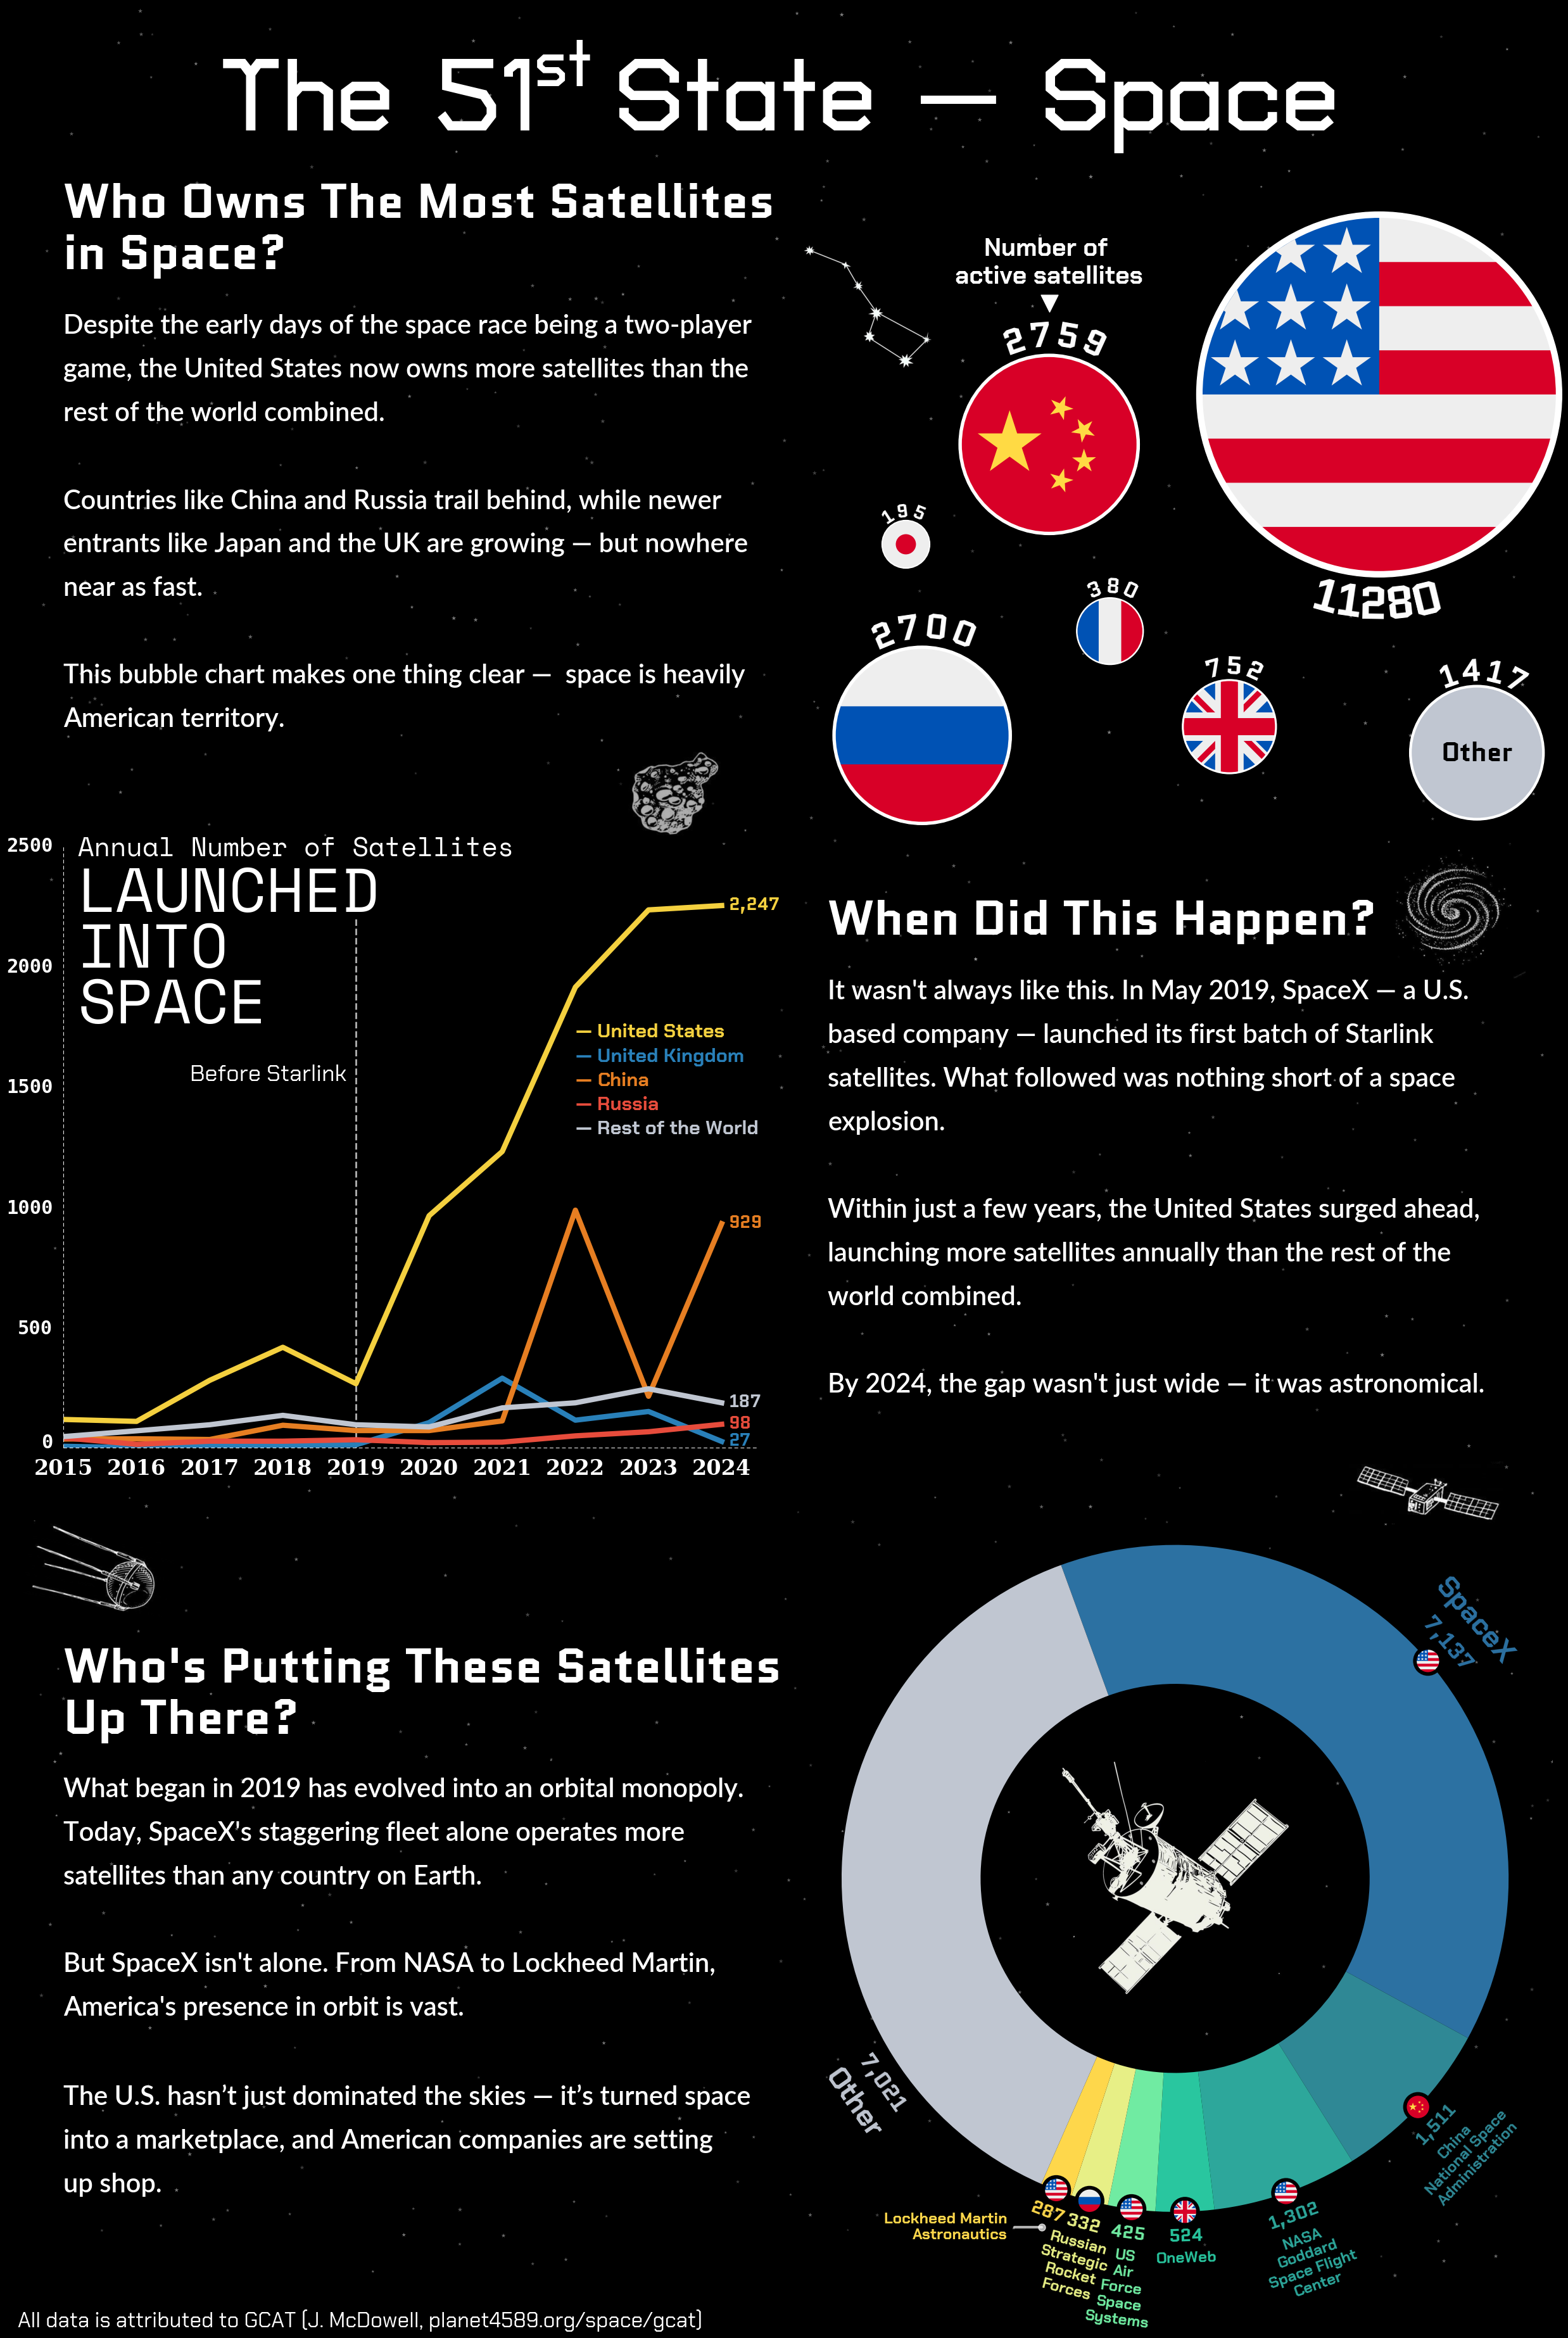

In [18]:
fig = plt.figure(figsize=(24, 36), facecolor='black')
gs = GridSpec(3, 2, figure=fig, 
              width_ratios=[12, 12], 
              height_ratios=[12, 10, 12],
              left=0.02,
              right=0.98,
              bottom=0.02,
              top=0.98,
              wspace=0.1,
              hspace=0.1)

def add_infographic_stars(fig, num_stars=500, max_size=30, min_size=10, max_alpha=0.5, min_alpha=0.2):
    ax_stars = fig.add_axes([0, 0, 1, 1], facecolor='none', zorder=-1)
    ax_stars.set_xlim(0, 1)
    ax_stars.set_ylim(0, 1)
    ax_stars.axis('off')
    
    np.random.seed(42)
    star_x = np.random.rand(num_stars)
    star_y = np.random.rand(num_stars)
    star_sizes = np.random.uniform(min_size, max_size, num_stars)
    star_alphas = np.random.uniform(min_alpha, max_alpha, num_stars)
    
    ax_stars.scatter(star_x, star_y, 
                    s=star_sizes, 
                    c='white', 
                    alpha=star_alphas, 
                    marker='*',
                    edgecolors='none')

ax_empty1 = fig.add_subplot(gs[0, 0], facecolor='black')  # Top left (empty)
ax_empty2 = fig.add_subplot(gs[1, 1], facecolor='black')  # Middle right (empty)
ax_empty3 = fig.add_subplot(gs[2, 0], facecolor='black')  # Bottom left (empty)

ax_empty1.set_axis_off()
ax_empty2.set_axis_off()
ax_empty3.set_axis_off()

flags = Flags("circle")

def configure_bubble_plot(ax):
    ax.set_aspect('equal')
    ax.set_xlim(-45, 115)
    ax.set_ylim(-120, 40)
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])

def get_circle_properties(country, scale_factor=0.275):
    count = top_10[country]
    return np.sqrt(count) * scale_factor

def create_country_bubbles(ax):
    other_radius = get_circle_properties('Other')
    ax.add_patch(patches.Circle((104.5, -118), other_radius*1.5,
                               color='white', alpha=1, clip_on=False))

    for country, (x, y) in positions.items():
        radius = get_circle_properties(country)
        
        circle_color = '#C0C6D1' if country == 'Other' else 'white'
        ax.add_patch(patches.Circle((x, y), radius*1.44,
                                   color=circle_color, alpha=1, clip_on=False))
        
        if country != "Other":
            country_code = {
                "UK": "GB",
                "F": "FR",
                "J": "JP"
            }.get(country, country)
            
            da = flags.get_drawing_area(country_code, wmax=radius*13.75)
            ab = AnnotationBbox(da, (x, y), frameon=False, box_alignment=(0.5, 0.5))
            ax.add_artist(ab)
        
        theta = (np.linspace(3*np.pi/2, 7*np.pi/2, 100)) if country in ["F", "J"] else np.linspace(0, 2*np.pi, 100)
        
        if country == "US":
            text_x = x - (radius * text_adjustments[country]) * np.cos(theta)
            text_y = y - (radius * text_adjustments[country]) * np.sin(theta)
        else:
            text_x = x + (radius * text_adjustments[country]) * -np.cos(theta)
            text_y = y + (radius * text_adjustments[country]) * np.sin(theta)
        
        padding = {
            'US': " " * 54,
            'CN': " " * 18,
            'RU': " " * 17,
            'F': " " * 15,
            'J': " " * 9,
            'Other': " " * 12
        }.get(country, " " * 9)
        
        CurvedText(
            x=text_x, y=text_y,
            text=padding + f"{top_10[country]}",
            va="bottom", axes=ax,
            fontsize=font_sizes[country],
            font=quan_bold, fontweight="bold",
            color='white', clip_on=False
        )

payloads = df[df['Type'].str.contains('P', na=False) & df["Status"].isin(["O"])]
payload_counts = payloads.State.value_counts()
top_10 = payload_counts.head(10).to_dict()
top_10["Other"] = payload_counts.iloc[5:].sum()

positions = {
    "US": (82, -35.5), "CN": (6, -47), "RU": (-23.25, -114),
    "Other": (104.5, -118), "UK": (47.5, -112), "F": (20, -90), "J": (-27, -70)
}

colors = {
    "US": "#F4D03F", "CN": "#E67E22", "RU": "#E74C3C",
    "Other": "#C0C6D1", "UK": "#2980B9", "F": "#16A085", "J": "#2ECC71"
}

font_sizes = {
    "US": 52, "CN": 40, "RU": 40, "Other": 35,
    "UK": 29, "F": 24, "J": 21
}

text_adjustments = {
    "US": 1.84, "CN": 1.45, "RU": 1.45, "Other": 1.45,
    "UK": 1.45, "F": 1.44, "J": 1.4
}

ax1 = fig.add_subplot(gs[0, 1], facecolor='black')
configure_bubble_plot(ax1)
create_country_bubbles(ax1)

ax1.scatter(6, -14.5, marker='v', s=375, color='white')
ax1.text(6, -10, "Number of \nactive satellites", 
         ha='center', color='white', 
         font=chakra_bold, fontsize=28)

ax1.text(104.5, -120, 'Other',
        ha='center', font=quan_bold,
        fontsize=30)

# PLOT 2 - Line Chart
def configure_plot_style(ax):
    plt.rcParams['font.family'] = 'serif'
    ax.set_facecolor('black')
    
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_linestyle((0, (5, 5)))
        ax.spines[spine].set_linewidth(0.7)
        ax.spines[spine].set_color('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.tick_params(axis='both', which='both', length=0)
    ax.tick_params(axis='x', labelsize=24, colors='white')
    ax.tick_params(axis='y', labelsize=22, colors='white')
    
    for label in ax.get_xticklabels():
        label.set_fontfamily('serif')
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('monospace')
    
    ax.xaxis.set_tick_params(pad=12)
    ax.yaxis.set_tick_params(pad=12)

def add_annotations(ax):
    titles = [
        (2015.2, 2450, 'Annual Number of Satellites', 30),
        (2015.2, 2220, 'LAUNCHED', 70),
        (2015.2, 1990, 'INTO', 70),
        (2015.2, 1760, 'SPACE', 70)
    ]
    for x, y, text, size in titles:
        ax.text(x, y, text, font=spacemono, fontsize=size, color='white')
    
    legend_items = [
        (2022, 1700, '#F4D03F', 'United States'),
        (2022, 1600, '#2980B9', 'United Kingdom'),
        (2022, 1500, '#E67E22', 'China'),
        (2022, 1400, '#E74C3C', 'Russia'),
        (2022, 1300, '#C0C6D1', 'Rest of the World')
    ]
    for x, y, color, text in legend_items:
        ax.text(x, y, '—', font=chakra_bold, fontsize=25, color=color)
        ax.text(x + 0.3, y, text, font=chakra_bold, fontsize=22, color=color)

ax2 = fig.add_subplot(gs[1, 0], facecolor='black')
configure_plot_style(ax2)

df_copy = df.copy()
df_copy["Launch_Year"] = pd.to_datetime(df_copy["LDate"], errors="coerce").dt.year
df_copy = df_copy[df_copy['Type'].str.contains('P', na=False)]
df_copy = df_copy[["Launch_Year", "State"]].dropna()

top_countries = {"US": "United States", "CN": "China", "RU": "Russia", "UK": "United Kingdom"}
df_copy["Country"] = df_copy["State"].map(top_countries).fillna("Other")
launch_counts = df_copy.groupby(["Launch_Year", "Country"]).size().unstack(fill_value=0)
launch_counts = launch_counts[launch_counts.index < 2025]

colors = {
    "United States": "#F4D03F",
    "China": "#E67E22",
    "Russia": "#E74C3C",
    "United Kingdom": "#2980B9",
    "Other": "#C0C6D1"
}

order = ['United States', 'United Kingdom', "China", "Russia", "Other"]

ax2.plot([2019, 2019], [0, 2200], color='white', linestyle='--', linewidth=2, alpha=0.7, clip_on=False)
ax2.text(2017.8, 1500, 'Before Starlink', ha='center', va='bottom',
        fontsize=26, color='white', bbox=dict(facecolor='black', edgecolor='none', pad=3),
        font=chakra)

for country in order:
    if country in launch_counts.columns:
        ax2.plot(launch_counts.index, launch_counts[country], 
                label=country, color=colors[country], linewidth=6)

ax2.set_xticks(range(2015, 2025))
ax2.set_xlim(2015, 2024.5)
ax2.set_ylim(0, 2500)

add_annotations(ax2)

last_year = 2024
for country in order:
    if country in launch_counts.columns:
        count = launch_counts.at[last_year, country]
        ax2.text(2024.1, count, f"{count:,}", ha='left', va='center',
                fontsize=20, color=colors[country], font=quan_bold)

current_yticks = ax2.get_yticks()
new_yticks = [tick for tick in current_yticks if tick != 0]
new_yticks.append(30)
ax2.set_yticks(sorted(new_yticks))
ax2.set_yticklabels([str(int(tick)) if tick != 30 else '0' for tick in sorted(new_yticks)])

# PLOT 3 - Donut Chart
def configure_donut_chart(ax):
    ax.set_aspect('equal')
    ax.set_facecolor('black')

def prepare_owner_data(df):
    owners = df[df['Type'].str.contains('P', na=False) & df["Status"].isin(["O"])]
    owners = owners.groupby(['ShortName', 'Name_y', 'State']).size()
    owners = owners.reset_index(name='Count').sort_values(by='Count', ascending=False)
    
    name_replacements = {
        "SpaceX (Seattle)": "SpaceX",
        "Guojia Hangtian Ju": "China\nNational Space\nAdministration",
        "NASA Goddard Space Flight Center": "NASA\nGoddard\nSpace Flight\nCenter",
        "One Web (Network Access Associates Ltd.)": "OneWeb",
        "US Air Force Space Systems Division": "US\nAir\nForce\nSpace\nSystems",
        "Rakentiye Voiska Strategicheskogo Naznacheniye (Rossisk. Fed.)": "Russian\nStrategic\nRocket\nForces",
        "United Launch Alliance/Lockheed Martin Astronautics": "Lockheed\nMartin\nAstronautics"
    }
    owners["Name_y"] = owners["Name_y"].replace(name_replacements)
    
    top_owners = owners.head(7)
    rest_count = owners.iloc[7:]["Count"].sum()
    other_df = pd.DataFrame([{
        "ShortName": "Other", "Name_y": "Other", 
        "State": "", "Count": rest_count
    }])
    
    return pd.concat([top_owners, other_df], ignore_index=True)

def create_donut_chart(ax, data):
    colors = {
        "SpaceX": "#2c71a2",
        "China\nNational Space\nAdministration": "#2f8895",
        "NASA\nGoddard\nSpace Flight\nCenter": "#2da79b",
        "OneWeb": "#29c69f",
        "US\nAir\nForce\nSpace\nSystems": "#70eba2",
        "Russian\nStrategic\nRocket\nForces": "#e7ef86",
        "Lockheed\nMartin\nAstronautics": "#fed74b",
        "Other": "#C0C6D1"
    }
    
    text_adjustments = {
        "SpaceX": 1.18, "China\nNational Space\nAdministration": 1.2,
        "NASA\nGoddard\nSpace Flight\nCenter": 1.22, "OneWeb": 1.14,
        "US\nAir\nForce\nSpace\nSystems": 1.24, 
        "Russian\nStrategic\nRocket\nForces": 1.205, "Other": 1.18
    }
    
    offset = 0.3
    scale = 1.2
    start_angle = 110
    
    wedges, _ = ax.pie(
        data["Count"],
        labels=None,
        colors=[colors[name] for name in data["Name_y"]],
        startangle=start_angle,
        counterclock=False,
        wedgeprops={'width': 0.5},
        radius=scale,
        center=(0, offset)
    )
    
    for wedge, label, count in zip(wedges, data["Name_y"], data["Count"]):
            
        center_angle = (wedge.theta1 + wedge.theta2) / 2
        text_radius = text_adjustments.get(label, 1.0) * scale
        
        if label == "Other":
            center_angle = -145
        rotation = center_angle + 90
        if label == "SpaceX":
            rotation -= 180
            
        x = text_radius * np.cos(np.deg2rad(center_angle))
        y = text_radius * np.sin(np.deg2rad(center_angle)) + offset

        if label != "Lockheed\nMartin\nAstronautics":
            ax.text(x, y, label,
                   rotation=rotation,
                   ha='center', va='center',
                   font=chakra_bold,
                   fontsize=32.5 if label in ["SpaceX", "Other"] else 17.5,
                   color=colors[label])
        
        value_radius = 1.075 * scale
        x_val = value_radius * np.cos(np.deg2rad(center_angle))
        y_val = value_radius * np.sin(np.deg2rad(center_angle)) + offset
        
        ax.text(x_val, y_val, f"{count:,}",
               rotation=rotation,
               ha='center', va='center',
               font=quan_bold,
               fontsize=25.5 if label in ["SpaceX", "Other"] else 20.5,
               color=colors[label])
    
    for wedge, state in zip(wedges, data["State"]):
        if pd.isna(state) or state == "":
            continue
            
        center_angle = (wedge.theta1 + wedge.theta2) / 2
        
        flag_size = 0.255
        flag_distance = 1.2
        
        x = flag_distance * np.cos(np.deg2rad(center_angle))
        y = flag_distance * np.sin(np.deg2rad(center_angle)) + offset
        
        ax.add_patch(Circle(
            (x, y),
            flag_size*0.18,
            ec='black',
            fc='none',
            lw=4.8,
            alpha=1)
        )
        
        da = flags.get_drawing_area(state, wmax=flag_size*100)
        ab = AnnotationBbox(da, (x, y), frameon=False, box_alignment=(0.5, 0.5))
        ax.add_artist(ab)
    
    lockheed_angle = (wedges[6].theta1 + wedges[6].theta2) / 2
    dot_radius = 1.12 * scale
    dot_x = dot_radius * np.cos(np.deg2rad(lockheed_angle))
    dot_y = dot_radius * np.sin(np.deg2rad(lockheed_angle)) + offset
    
    ax.plot(dot_x, dot_y, 'o', markersize=8, color='white',
           zorder=10, alpha=0.7, clip_on=False)
    ax.plot([dot_x - 0.1, dot_x], [dot_y, dot_y], color='white',
           lw=3, alpha=0.7, zorder=10, solid_capstyle='round', clip_on=False)
    ax.text(dot_x - 0.125, dot_y, "Lockheed Martin\nAstronautics",
           ha='right', va='center', font=chakra_bold, fontsize=17.5,
           color='#fed74b', linespacing=1.2)
    
    satellite_img = plt.imread('img/satellite1.png')
    imagebox = OffsetImage(satellite_img, zoom=0.35, resample=True)
    ab = AnnotationBbox(imagebox, (0, offset), frameon=False, box_alignment=(0.5, 0.5))
    ax.add_artist(ab)
    
    ax.add_patch(plt.Circle((0, offset), 0.3, fc='black'))

ax3 = fig.add_subplot(gs[2, 1], facecolor='black')
configure_donut_chart(ax3)
owner_data = prepare_owner_data(df)
create_donut_chart(ax3, owner_data)

# Annotations, images, etc
def add_image(ax, image_path, x, y, zoom=1.0, angle=0, alpha=1.0, 
              box_alignment=(0.5, 0.5), frameon=False, 
              xycoords='axes fraction', clip_on=False):
    try:
        img = plt.imread(image_path)
        img = img_as_float(img)
        
        if angle != 0:
            img = rotate(img, angle=angle, reshape=True)
        
        imagebox = OffsetImage(img, zoom=zoom, resample=True, alpha=alpha)
        ab = AnnotationBbox(imagebox, (x, y), 
                           frameon=frameon,
                           xycoords=xycoords,
                           box_alignment=box_alignment,
                           clip_on=clip_on)
        ax.add_artist(ab)
    except FileNotFoundError:
        pass

add_image(ax1, 'img/constellation.png', 0.06, 0.65, zoom=0.25)
add_image(ax3, 'img/satellite2.png', 0.75, 1.1, zoom=0.5, box_alignment=(0, 1), clip_on=False)
add_image(ax_empty3, 'img/satellite3.png', 0.05, 0.92, zoom=0.4, angle=170)
add_image(ax_empty1, 'img/asteroid.png', 0.8, 0.05, zoom=0.5, alpha=0.7, box_alignment=(0, 1), clip_on=False)
add_image(ax_empty2, 'img/spiral.png', 0.8, 1, zoom=0.5, alpha=0.9, box_alignment=(0, 1), clip_on=False)


ax_empty1.text(1, 0.925, ' The 51  State — Space', 
              fontsize=115, ha='center', va='center', color='white', font=turret,
              transform=ax_empty1.transAxes, clip_on=False)

ax_empty1.text(0.72, 0.975, 'st', 
              fontsize=75, ha='center', va='center', color='white', font=turret,
              transform=ax_empty1.transAxes, clip_on=False)

ax_empty1.text(0, 0.7, "Who Owns The Most Satellites\nin Space?",
               ha='left',
               fontsize=55,
               font=quan_bold,
               transform=ax_empty1.transAxes,
               color='white')

ax_empty1.text(0, 0.35,
        dedent("""
                       Despite the early days of the space race being a two-player
                       game, the United States now owns more satellites than the
                       rest of the world combined.
                       
                       Countries like China and Russia trail behind, while newer 
                       entrants like Japan and the UK are growing — but nowhere
                       near as fast.

                       This bubble chart makes one thing clear —  space is heavily
                       American territory.
                """),
                ha='left',
               va='center',
               transform=ax_empty1.transAxes,
               fontsize=30,
               font=lato,
               color='white',
               linespacing=2)

ax_empty2.text(0, 0.85, "When Did This Happen?",
               ha='left',
               fontsize=55,
               font=quan_bold,
               transform=ax_empty2.transAxes,
               color='white')

ax_empty2.text(0, 0.43,
        dedent("""
                       It wasn't always like this. In May 2019, SpaceX — a U.S. 
                       based company — launched its first batch of Starlink 
                       satellites. What followed was nothing short of a space
                       explosion.
                       
                       Within just a few years, the United States surged ahead,
                       launching more satellites annually than the rest of the
                       world combined.

                       By 2024, the gap wasn't just wide — it was astronomical.
                """),
                ha='left',
               va='center',
               transform=ax_empty2.transAxes,
               fontsize=30,
               font=lato,
               color='white',
               linespacing=2)

ax_empty3.text(0, 0.7, "Who's Putting These Satellites\nUp There?",
               ha='left',
               fontsize=55,
               font=quan_bold,
               transform=ax_empty3.transAxes,
               color='white')

ax_empty3.text(0, 0.35,
        dedent("""
                       What began in 2019 has evolved into an orbital monopoly.
                       Today, SpaceX's staggering fleet alone operates more
                       satellites than any country on Earth.
                       
                       But SpaceX isn't alone. From NASA to Lockheed Martin, 
                       America's presence in orbit is vast.

                       The U.S. hasn’t just dominated the skies — it’s turned space
                       into a marketplace, and American companies are setting
                       up shop. 
                """),
                ha='left',
               va='center',
               transform=ax_empty3.transAxes,
               fontsize=30,
               font=lato,
               color='white',
               linespacing=2)

citation_text = "All data is attributed to GCAT (J. McDowell, planet4589.org/space/gcat)"
fig.text(-0.01, -0.02, citation_text, 
         fontsize=24, 
         color='white', 
         font=chakra,
         ha='left',
         va='bottom')

add_infographic_stars(fig, num_stars=700)
plt.savefig('infographic.png', dpi=300, bbox_inches='tight')